# Worm-eating Warbler - TWS2019

### General Setup  
Fill out the next cell.

In [32]:
eval_id = 'tws2019'
gap_id = 'bwewax'
wsw_id = 'bwewax0'
notebook_name = gap_id + eval_id + ".ipynb"
summary_name = 'wormie1' # an short, memorable name to use for file names etc.
codeDir = '/users/nmtarr/code/GAP-range-evaluation/'
inDir = '/users/nmtarr/documents/GAP_Ranges/inputs/'
outDir = '/users/nmtarr/documents/GAP_Ranges/outputs/'
eval_db = outDir + gap_id + eval_id + '.sqlite'
request_id = "GBIFr14"
filter_id = "GBIFf4"
occ_db = '/users/nmtarr/documents/occurrence_records/outputs/{0}{1}{2}.sqlite'.format(wsw_id, request_id, filter_id)
wsw_db = '/users/nmtarr/code/occurrence-records-wrangler/parameters.sqlite'
parameters_db = '/users/nmtarr/code/GAP-range-evaluation/evaluations.sqlite'
shucs_loc = '/users/nmtarr/data/SHUCS'

connection = sqlite3.connect(wsw_db)
common_name = connection.execute("SELECT common_name FROM species_concepts WHERE gap_id = ?;", (gap_id,)).fetchone()[0]
sci_name = connection.execute("SELECT scientific_name FROM species_concepts WHERE gap_id = ?;", (gap_id,)).fetchone()[0]

In [2]:
%matplotlib inline
import sqlite3
import pprint
import pandas as pd
#import geopandas as gpd
pd.set_option('display.width', 600)
pd.set_option('display.max_colwidth', 60)
pd.set_option('display.max_rows', 100)
from IPython.display import Image
import repo_functions as functions
from pygbif import occurrences
import matplotlib.pyplot as plt
from datetime import datetime
import os

## Evaluation Parameters

Evaluation parameters need to be set and justified in the cells within this section.  Values that are entered here will be used to update cells within the 'evaluations' table stored in evaluations.sqlite. The decisions about what values to use are primarily documented here, not in the evaluations database.

Note that the evaluation ID and species' GAP code are set in the cell above, not below.  I am proposing that evaluation parameter sets also be documented as unique entities in a database (i.e, evaluations.sqlite).  Each evaluation can be given a unique id that can be used in documentation, file naming, and for the names of the columns that will be added to the GAP range table to record the results of the evaluation.  In this example, the evaluation_id is __tws2019__.

### Filter Sets

In [3]:
filter_sets = "{0}, {1}".format(request_id, filter_id)

### Years
Justification: A fair number of records exist for this species, so I chose 2 old years.

In [4]:
years = "2001, 2002"

### Months
Justification: The species does not winter in the US, so only summer months are relevant.  The choice in months was informed by the Birds of North America online species account.

In [5]:
months = "5,6,7"

### Evaluation Method
Justification: The restrictive nature of "proportion in polygon" is a good fit for the demonstration of the framework.

In [6]:
method = "proportion in polygon"

#### Minimum Count
Justification: This species is fairly easy to identify, but misidentification could be possible.

In [7]:
min_count = 1

#### Error Tolerance
Justification: The species is not super-abundant and is uncommon in many places, but not rare.  40% chance of error seems pretty liberal at this point.

In [8]:
error_tolerance = 40

### Credits

In [9]:
creator = "Nathan Tarr"
date = datetime.now()

### Justification

In [10]:
justification = "See " + notebook_name

### Notes

In [11]:
notes = """For development"""

### Write to evaluations.sqlite

In [12]:
connjup = sqlite3.connect(parameters_db)
cursorjup = connjup.cursor()

# Make a row for species-evaluation
sqlrow = """INSERT OR IGNORE INTO evaluations ("evaluation_id", "species_id") VALUES (?, ?);"""
vals = [eval_id, gap_id]
cursorjup.execute(sqlrow, vals)

# Filter sets
sqlfilters = """UPDATE evaluations SET filter_sets=? WHERE evaluation_id=? AND species_id=?;"""
vals = [filter_sets, eval_id, gap_id]
cursorjup.execute(sqlfilters, vals)

# Years
sqlyear = """UPDATE evaluations SET years=? WHERE evaluation_id=? AND species_id=?;"""
vals = [years, eval_id, gap_id]
cursorjup.execute(sqlyear, vals)

# Months
sqlmonths = """UPDATE evaluations SET months=? WHERE evaluation_id=? AND species_id=?;"""
vals = [months, eval_id, gap_id]
cursorjup.execute(sqlmonths, vals)

# Evaluation Method
sqlmethod = """UPDATE evaluations SET method=? WHERE evaluation_id=? AND species_id=?"""
vals = [method, eval_id, gap_id]
cursorjup.execute(sqlmethod, vals)

# Minimum Count
sqlmin = """UPDATE evaluations SET min_count=? WHERE evaluation_id=? AND species_id=?"""
vals = [min_count, eval_id, gap_id]
cursorjup.execute(sqlmin, vals)

# Error Tolerance
sqltolerance = """UPDATE evaluations SET error_tolerance=? WHERE evaluation_id=? AND species_id=?"""
vals = [error_tolerance, eval_id, gap_id]
cursorjup.execute(sqltolerance, vals)

# Justification
sqljust = """UPDATE evaluations SET justification=? WHERE evaluation_id=? AND species_id=?"""
vals = [justification, eval_id, gap_id]
cursorjup.execute(sqljust, vals)

# Credits
sqlcreator = """UPDATE evaluations SET creator=? WHERE evaluation_id=? AND species_id=?"""
vals = [creator, eval_id, gap_id]
cursorjup.execute(sqlcreator, vals)

# Notes
sqlnotes = """UPDATE evaluations SET notes=? WHERE evaluation_id=? AND species_id=?"""
vals = [notes, eval_id, gap_id]
cursorjup.execute(sqlnotes, vals)

sqldate= """UPDATE evaluations SET date=? WHERE evaluation_id=? AND species_id=?"""
vals = [date, eval_id, gap_id]
cursorjup.execute(sqldate, vals)

connjup.commit()

### Evaluation Parameters
Display the record that was just written.

In [13]:
df1 = pd.read_sql_query(sql="SELECT * FROM evaluations WHERE evaluation_id='{0}' AND species_id='{1}'".format(eval_id, gap_id), con=connjup)
print(df1.loc[0])

evaluation_id                         tws2019
species_id                             bwewax
years                              2001, 2002
months                                  5,6,7
min_count                                   1
error_tolerance                            40
method                  proportion in polygon
filter_sets                   GBIFr14, GBIFf4
justification         See bwewaxtws2019.ipynb
creator                           Nathan Tarr
date               2019-08-15 15:14:56.673530
notes                         For development
Name: 0, dtype: object


### Request Filter Set

In [14]:
filterconn = sqlite3.connect(wsw_db)
df2 = pd.read_sql_query(sql="SELECT * FROM gbif_requests WHERE request_id='{0}'".format(request_id), con=filterconn)
print(df2.loc[0])

request_id                                                          GBIFr14
source                                                                 GBIF
lat_range                                                             27,41
lon_range                                                           -91,-75
years_range                                                       2000,2002
months_range                                                           1,12
geoissue                                                              False
coordinate                                                             True
continent                                                              None
creator                                                             N. Tarr
notes           For evaluating 2001 GAP range maps.  Are the years correct?
Name: 0, dtype: object


### Post Request Filter Set

In [15]:
df2 = pd.read_sql_query(sql="SELECT * FROM gbif_filters WHERE filter_id = '{0}'".format(filter_id), con=filterconn)
print(df2.loc[0])
filterconn.close()

filter_id                                                                          GBIFf4
dataset                                                                              GBIF
collection_codes_omit                                                                None
institutions_omit                                                                    None
has_coordinate_uncertainty                                                              0
max_coordinate_uncertainty                                                           5000
bases_omit                                            PRESERVED_SPECIMEN, FOSSIL_SPECIMEN
protocols_omit                                                                       None
sampling_protocols_omit                                                              None
issues_omit                   GEODETIC_DATUM_INVALID, INDIVIDUAL_COUNT_INVALID, MULTIM...
creator                                                                           N. Tarr
notes     

# Occurrence Record Retrieval and Display
This repo is dependent upon the occorrence-records-wrangler repo because occurrence data is retrieved here from sqlite occurrence databases generated with the records wrangler repo.  In this section, a connection is established and records are filtered according to the evaluation parameters.  Keep in mind that the occurrence record databases were themselves created with filters so you have to be mindful of how parameters set here compare to ones set there. For example, dates of records included will be determined by whichever process had a more restrictive date range. 

The first step in using occurrence records to evaluate GAP range is to build a database to hold the GAP 12 digit HUCs, range for the species, and suitable occurrence records.  The database is also suitable for performing the necessary spatial queries.  The GAP range is retrieved from ScienceBase and the HUCs would be too if they were available as a shapefile.  

In [16]:
functions.make_evaluation_db(eval_db=eval_db, gap_id=gap_id, shucLoc=shucs_loc, inDir=inDir)

Copy records to the evaluation database, filtering out records from months or years that aren't wanted.

In [17]:
# Connect to the evaluation occurrence records database
evconn = sqlite3.connect(eval_db)
os.putenv('SPATIALITE_SECURITY', 'relaxed')
evconn.enable_load_extension(True)
cursor = evconn.cursor()
cursor.executescript("""SELECT load_extension('mod_spatialite');""")

# Attach occurrence database
cursor.execute("ATTACH DATABASE ? AS occs;", (occ_db,))

# Create table of occurrences that fit within evaluation parameters
years = tuple([x.strip() for x in years.split(',')])
months = tuple([x.strip().zfill(2) for x in months.split(',')])
cursor.execute("""CREATE TABLE evaluation_occurrences AS 
                   SELECT * FROM occs.occurrences 
                   WHERE STRFTIME('%Y', OccurrenceDate) IN {0} 
                       AND STRFTIME('%m', OccurrenceDate) IN {1};""".format(years, months))

# Export occurrence circles as a shapefile (all seasons)
cursor.execute("""SELECT RecoverGeometryColumn('evaluation_occurrences', 'circle_wgs84', 
                  4326, 'POLYGON', 'XY');""")

sql = """SELECT ExportSHP('evaluation_occurrences', 'circle_wgs84', ?, 'utf-8');"""
subs = outDir + summary_name + "_circles"
cursor.execute(sql, (subs,))

# Export occurrence 'points' as a shapefile (all seasons)
cursor.execute("""SELECT RecoverGeometryColumn('evaluation_occurrences', 'geom_xy4326', 
                  4326, 'POINT', 'XY');""")
subs = outDir + summary_name + "_points"
cursor.execute("""SELECT ExportSHP('evaluation_occurrences', 'geom_xy4326', ?, 'utf-8');""", (subs,))

# Close db
evconn.commit()
evconn.close()
del cursor

### Display Occurrence Points and GAP Range Map
Get the GAP range map

In [18]:
gap_range = functions.download_GAP_range_CONUS2001v1(gap_id, inDir)

# Reproject the GAP range to WGS84 and export to shapefile for displaying
conn3 = sqlite3.connect(':memory:')
os.putenv('SPATIALITE_SECURITY', 'relaxed')
conn3.enable_load_extension(True)
cursor3 = conn3.cursor()
sql_repro = """
SELECT load_extension('mod_spatialite');

SELECT InitSpatialMetadata(1);

SELECT ImportSHP('{0}{1}_conus_range_2001v1', 'rng3', 'utf-8', 5070,
                 'geom_5070', 'HUC12RNG', 'MULTIPOLYGON');

CREATE TABLE rng2 AS SELECT HUC12RNG, seasonCode, seasonName,
                            Transform(geom_5070, 4326) AS geom_4326 FROM rng3;

SELECT RecoverGeometryColumn('rng2', 'geom_4326', 4326, 'MULTIPOLYGON', 'XY');

SELECT ExportSHP('rng2', 'geom_4326', '{0}{1}_range_4326', 'utf-8');
""".format(inDir, gap_id)

cursor3.executescript(sql_repro)
conn3.close()
del cursor3

gap_range2 = "{0}{1}_range_4326".format(inDir, gap_id)

downloading https://www.sciencebase.gov/catalog/file/get/59f5ebb4e4b063d5d307e0d1?f=__disk__1c%2F00%2F75%2F1c00755f339c97bafe6c9d1c69ee14cef5326d7c to /users/nmtarr/documents/GAP_Ranges/inputs/bWEWAx_CONUS_Range_2001v1.zip
downloading https://www.sciencebase.gov/catalog/file/get/59f5ebb4e4b063d5d307e0d1?f=__disk__7c%2F1d%2Fc7%2F7c1dc7208c25d4ed06614642f32dbac70c2aa2d5 to /users/nmtarr/documents/GAP_Ranges/inputs/bWEWAx_CONUS_Range_2001v1.xml


Display occurrence records over GAP range

In [26]:
shp1 = {'file': gap_range2, 'column': None, 'alias': 'GAP range map',
        'drawbounds': False, 'linewidth': .5, 'linecolor': 'y',
        'fillcolor': 'y', 'marker':'s'}

shp2 = {'file': '{0}{1}_circles'.format(outDir, summary_name), 'column': None,
        'alias': 'Occurrence records', 'drawbounds': True, 'linewidth': .75, 'linecolor': 'k',
        'fillcolor': None, 'marker':'o'}

# Display occurrence polygons
title="{1} ({0})".format(years, sci_name)
#functions.MapShapefilePolygons(map_these=[shp1, shp2], title=title)

# GAP Known Range Data Evaluation
With all the data in a sqlite database with spatialite capabilities, we can perform the evaluation.

In [20]:
functions.evaluate_GAP_range(eval_id=eval_id, gap_id=gap_id, eval_db=eval_db,
                             outDir=outDir, codeDir=codeDir, method='Proportion in polygon')

In [21]:
connr = sqlite3.connect(eval_db)
df4 = pd.read_sql_query(sql="SELECT strHUC12RNG AS HUC12RNG, "
                                    "intGAPOrigin AS Origin, intGAPPresence AS Presence, "
                                    "intGAPReproduction AS Reproduction,"
                                    "intGAPSeason AS Season, eval_cnt, eval, "
                                    "validated_presence AS validated_pres FROM new_range WHERE eval_cnt >=0", con=connr)
df4.set_index(["HUC12RNG"], inplace=True)
print("Tabular results of the evaluation")
print(df4)

Tabular results of the evaluation
              Origin  Presence  Reproduction  Season  eval_cnt  eval  validated_pres
HUC12RNG                                                                            
110100080206       1         1             1       4         1     1               1
60102020401        1         1             1       4         1     1               1
11000050604        1         1             1       4         1     1               1
20700090701        1         1             1       4         1     1               1
20600060301        1         1             1       4         1     1               1
20801090102        1         1             1       4         1     1               1
20700100306        1         1             1       4         1     1               1
20403030101        1         1             1       4         1     1               1
20403030502        1         1             1       4         2     1               1
20600060103        1         1 

Mapped results of the evaluation.


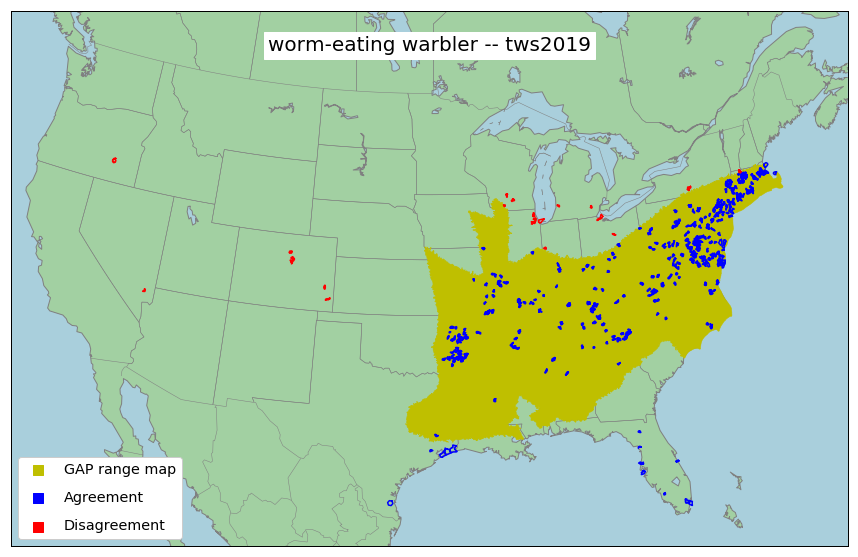

In [33]:
print("Mapped results of the evaluation.")
shp3 = {'file': '{0}{1}_eval'.format(outDir, gap_id), 'column': 'eval',
        'alias': 'eval', 'column_colors': {1: 'b', 0: 'r'}, 
        'value_alias': {1:'Agreement', 0:'Disagreement'}, 'drawbounds': False, 
        'marker': "s"}
title="{0} -- {1}".format(common_name, eval_id)
functions.MapShapefilePolygons(map_these=[shp1, shp3], title=title)

In [34]:
dups0 = connr.execute("SELECT COUNT(occ_id) FROM evaluation_occurrences GROUP BY geom_xy4326, occurrenceDate;").fetchall()
dups1 = [x[0] for x in dups0]
dups2 = [x for x in dups1 if x > 1]
print(str(len(dups2)) + ' records were duplicates based on xy coordinate and date-time')

88 records were duplicates based on xy coordinate and date-time


After occurrence circles are attributed to HUCs, the results can be recorded in the species' range map table in terms of whether the two data sets agreed and whether they validate the GAP range data for any HUCs. For each evaluation, a column is added for 1) how many records could be attributed to each huc and 2) whether there is agreement at that huc (1 for yes, 0 for no, 'None' for no data for that huc) and 3) whether the GAP range has been validated by the evaluation.

# Summary of Results

### How many records were available in the occurrence database?

In [ ]:
count = connr.execute("SELECT COUNT(;")

### How many of the records were attributable to a HUC?

In [37]:
hucable = connr.execute("SELECT SUM(eval_cnt) FROM new_range WHERE eval_cnt >=0").fetchall()[0]
print(str(hucable[0]) + " records were attributable to a HUC.")

1007 records were attributable to a HUC.


### How many hucs had records attributed to them?

In [42]:
containers = connr.execute("SELECT COUNT(eval_cnt) FROM new_range WHERE eval_cnt >=0").fetchall()[0]
print(str(containers[0]) + " HUCs 'contained' records.")

428 HUCs 'contained' records.


### How many records were not used because of the minimum count?

In [43]:
conn_rng = sqlite3.connect(outDir + gap_id + '_range.sqlite')
curs_rng = conn_rng.cursor()
ones = curs_rng.execute("SELECT SUM(eval_gbif1_cnt) FROM new_range WHERE eval_gbif1_cnt = 1").fetchall()[0]
print(str(ones[0]) + " HUCs had occurrences but were not validated because they didn't meet the minimum.")

OperationalError: no such table: new_range

### How many HUCs were validated?

In [46]:
validated = connr.execute("SELECT COUNT(validated_presence) FROM new_range WHERE {0} = 1".format(eval_id)).fetchall()[0]
print(str(validated[0]) + " HUCs were validated.")

OperationalError: no such column: tws2019

### How many HUCs did GAP appear to omit?

In [47]:
missed = curs_rng.execute("SELECT COUNT(eval) FROM new_range WHERE {0} = 0".format(eval_id)).fetchall()[0]
print(str(missed[0]) + " HUCs were missed.")

OperationalError: no such table: new_range

### What was the maximum number of occurrences attributable to a single HUC?

In [48]:
maxi = curs_rng.execute("SELECT MAX(eval_gbif1_cnt) FROM new_range").fetchall()[0]
print("The maximum number of records attributed to a HUC was " + str(maxi[0]))

OperationalError: no such table: new_range

# Next Steps
This is just a starting point that needs scrutiny.  It is currently hard-coded for a single species, so deploying it would require redesigning to accomodate large numbers of species, multiple users, many more occurrence records, optimal methods for evaluation and range delineation among other things.  